# Process Throughput Scaling Results

## Imports, Utils, Cfg, Etc

In [1]:
!hostname

nid00152


In [2]:
import itertools
import datetime
import glob
import os
import shutil
from statistics import median
from pathlib import Path
from configparser import ConfigParser

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
ROOT_DIR = Path("/lus/scratch/drozt/repos/ssdev/scale/results/throughput-standard-scaling")
RESULTS_DIR = ROOT_DIR / "official-loop-time"
PROCESSED_RESULTS_DIR = RESULTS_DIR / "my_results"
FORCE_RELOAD = False

In [4]:
sns.set_palette('colorblind')

## Agreed upon axis for study w/ Dragon

In [6]:
ax_client_nodes = [1, 16, 32, 64, 128]
ax_clients_per_node = [1, 8, 16, 32, 64]
ax_db_nodes = [8, 16, 32, 64, 128]
ax_db_cpus = [36]

# dragon pool does well up to 64
ax_tensor_bytes = [8, 16, 32, 1_024, 8_192, 16_384, 32_768, 65_536, 131_072, 262_144, 524_288, 1_048_576]

# dragon has managers
# we do not for redis :(
# if time for key db set number of threads
# num_dragon_managers = [1, 2, 4]

ax_iterations = [100]

## Agregate Findings Across MPI Ranks

### Load in Raw Data from Study

In [7]:
def open_and_add_ctx_to_out_file(
    csv_file_path,
    client_nodes,
    clients_per_node,
    db_nodes,
    db_cpus,
    tensor_bytes,
    iterations
):
    df = pd.read_csv(csv_file_path, index_col=None, names=["Rank", "Action", "Time (Seconds)"])
    return df

def aggregate_action_data_in_df(df):
    action_groups = df[["Action", "Time (Seconds)"]].groupby("Action")
    agg_data = {}
    for action, data in action_groups:
        times = data["Time (Seconds)"]
        agg_data.update({
            f"{action}_min": times.min(),
            f"{action}_mean": times.mean(),
            f"{action}_max": times.max()
        })
    return agg_data

In [9]:
def process_throughput_out_data(results_dir, processed_dir):
    composite_data = []
    agg_data = []
    for    client_nodes,    clients_per_node,    db_nodes,    db_cpus,    tensor_bytes,    iterations in tqdm(list(itertools.product(
        ax_client_nodes, ax_clients_per_node, ax_db_nodes, ax_db_cpus, ax_tensor_bytes, ax_iterations
    )), desc="Processing scaling results...", ncols=80):
        scale_out_dir = \
            f"throughput-sess-python-N{client_nodes}-T{clients_per_node}-DBN{db_nodes}-DBCPU{db_cpus}-ITER{iterations}-TB{tensor_bytes}-*"
        try:
            dir_, *other = glob.iglob(str(results_dir / scale_out_dir))
        except ValueError:
            print(f"Failed to find {scale_out_dir}")
            continue
        else:
            if other:
                print(f"WARNING: got extra, unexpected results dirs: {other};\n"
                       "         Ignoring for now!!")
        dfs = [
            open_and_add_ctx_to_out_file(
                str(csv),
                client_nodes,
                clients_per_node,
                db_nodes,
                db_cpus,
                tensor_bytes,
                iterations
            )
            for csv in glob.iglob(os.path.join(dir_, "rank_*_timing.csv"))
        ]
        if not dfs:
            print(f"missing csvs in {dir_}")
            continue
        ranks_data_df = pd.concat(dfs, ignore_index=True)
        assert len(pd.unique(ranks_data_df["Rank"])) == client_nodes * clients_per_node

        specs = {
            "client_nodes": client_nodes,
            "clients_per_node": clients_per_node,
            "database_nodes": db_nodes,
            "database_cpus": db_cpus,
            "iterations": iterations,
            "tensor_bytes": tensor_bytes,
        }
        composite_data.append(ranks_data_df.assign(**specs))
        # agg_data.append(pd.DataFrame([{
        #     **specs,
        #     **aggregate_action_data_in_df(ranks_data_df),
        # }]))

    composite_df = pd.concat(composite_data, ignore_index=True)
    # agg_df = pd.concat(agg_data, ignore_index=True)

    composite_df.to_csv(str(processed_dir / "composite.csv"), index=False)
    # agg_df.to_csv(str(processed_dir / "processed.csv"), index=False)
    return composite_df # , agg_df

def load_from_disk(res_dir, file="composite.csv"):
    return pd.read_csv(str(res_dir / file), index_col=None)
            # pd.read_csv(str(res_dir / "processed.csv"), index_col=None))

if PROCESSED_RESULTS_DIR.is_dir() and not FORCE_RELOAD:
    print(f"Processed results dir {PROCESSED_RESULTS_DIR} detected!")
    print("Loading data from disk")
    composite_df = load_from_disk(PROCESSED_RESULTS_DIR)
else:
    print("Processing and writing data to disk")
    shutil.rmtree(PROCESSED_RESULTS_DIR, ignore_errors=True)
    PROCESSED_RESULTS_DIR.mkdir()
    composite_df = process_throughput_out_data(RESULTS_DIR, PROCESSED_RESULTS_DIR)

Processing and writing data to disk


Processing scaling results...:  59%|█████▎   | 889/1500 [10:41<44:54,  4.41s/it]

missing csvs in /lus/scratch/drozt/repos/ssdev/scale/results/throughput-standard-scaling/official-loop-time/throughput-sess-python-N32-T64-DBN128-DBCPU36-ITER100-TB16-f60b
missing csvs in /lus/scratch/drozt/repos/ssdev/scale/results/throughput-standard-scaling/official-loop-time/throughput-sess-python-N32-T64-DBN128-DBCPU36-ITER100-TB32-96a4
missing csvs in /lus/scratch/drozt/repos/ssdev/scale/results/throughput-standard-scaling/official-loop-time/throughput-sess-python-N32-T64-DBN128-DBCPU36-ITER100-TB1024-db1f
missing csvs in /lus/scratch/drozt/repos/ssdev/scale/results/throughput-standard-scaling/official-loop-time/throughput-sess-python-N32-T64-DBN128-DBCPU36-ITER100-TB8192-6abf
missing csvs in /lus/scratch/drozt/repos/ssdev/scale/results/throughput-standard-scaling/official-loop-time/throughput-sess-python-N32-T64-DBN128-DBCPU36-ITER100-TB16384-d49c
missing csvs in /lus/scratch/drozt/repos/ssdev/scale/results/throughput-standard-scaling/official-loop-time/throughput-sess-python-N3

Processing scaling results...:  64%|█████▋   | 957/1500 [11:06<02:00,  4.52it/s]

missing csvs in /lus/scratch/drozt/repos/ssdev/scale/results/throughput-standard-scaling/official-loop-time/throughput-sess-python-N64-T1-DBN128-DBCPU36-ITER100-TB262144-2299
missing csvs in /lus/scratch/drozt/repos/ssdev/scale/results/throughput-standard-scaling/official-loop-time/throughput-sess-python-N64-T1-DBN128-DBCPU36-ITER100-TB524288-0dfd
missing csvs in /lus/scratch/drozt/repos/ssdev/scale/results/throughput-standard-scaling/official-loop-time/throughput-sess-python-N64-T1-DBN128-DBCPU36-ITER100-TB1048576-5bb2


Processing scaling results...:  67%|█████▍  | 1008/1500 [12:51<15:37,  1.91s/it]

missing csvs in /lus/scratch/drozt/repos/ssdev/scale/results/throughput-standard-scaling/official-loop-time/throughput-sess-python-N64-T8-DBN128-DBCPU36-ITER100-TB8-1b28
missing csvs in /lus/scratch/drozt/repos/ssdev/scale/results/throughput-standard-scaling/official-loop-time/throughput-sess-python-N64-T8-DBN128-DBCPU36-ITER100-TB16-0468
missing csvs in /lus/scratch/drozt/repos/ssdev/scale/results/throughput-standard-scaling/official-loop-time/throughput-sess-python-N64-T8-DBN128-DBCPU36-ITER100-TB32-45ae
missing csvs in /lus/scratch/drozt/repos/ssdev/scale/results/throughput-standard-scaling/official-loop-time/throughput-sess-python-N64-T8-DBN128-DBCPU36-ITER100-TB1024-fef6
missing csvs in /lus/scratch/drozt/repos/ssdev/scale/results/throughput-standard-scaling/official-loop-time/throughput-sess-python-N64-T8-DBN128-DBCPU36-ITER100-TB8192-0e34
missing csvs in /lus/scratch/drozt/repos/ssdev/scale/results/throughput-standard-scaling/official-loop-time/throughput-sess-python-N64-T8-DBN1

Processing scaling results...:  83%|██████▋ | 1248/1500 [40:44<02:07,  1.97it/s]

Failed to find throughput-sess-python-N128-T1-DBN128-DBCPU36-ITER100-TB8-*
Failed to find throughput-sess-python-N128-T1-DBN128-DBCPU36-ITER100-TB16-*
Failed to find throughput-sess-python-N128-T1-DBN128-DBCPU36-ITER100-TB32-*
Failed to find throughput-sess-python-N128-T1-DBN128-DBCPU36-ITER100-TB1024-*
Failed to find throughput-sess-python-N128-T1-DBN128-DBCPU36-ITER100-TB8192-*
Failed to find throughput-sess-python-N128-T1-DBN128-DBCPU36-ITER100-TB16384-*
Failed to find throughput-sess-python-N128-T1-DBN128-DBCPU36-ITER100-TB32768-*
Failed to find throughput-sess-python-N128-T1-DBN128-DBCPU36-ITER100-TB65536-*
Failed to find throughput-sess-python-N128-T1-DBN128-DBCPU36-ITER100-TB131072-*
Failed to find throughput-sess-python-N128-T1-DBN128-DBCPU36-ITER100-TB262144-*
Failed to find throughput-sess-python-N128-T1-DBN128-DBCPU36-ITER100-TB524288-*
Failed to find throughput-sess-python-N128-T1-DBN128-DBCPU36-ITER100-TB1048576-*


Processing scaling results...:  87%|██████▉ | 1308/1500 [44:06<12:23,  3.87s/it]

Failed to find throughput-sess-python-N128-T8-DBN128-DBCPU36-ITER100-TB8-*
Failed to find throughput-sess-python-N128-T8-DBN128-DBCPU36-ITER100-TB16-*
Failed to find throughput-sess-python-N128-T8-DBN128-DBCPU36-ITER100-TB32-*
Failed to find throughput-sess-python-N128-T8-DBN128-DBCPU36-ITER100-TB1024-*
Failed to find throughput-sess-python-N128-T8-DBN128-DBCPU36-ITER100-TB8192-*
Failed to find throughput-sess-python-N128-T8-DBN128-DBCPU36-ITER100-TB16384-*
Failed to find throughput-sess-python-N128-T8-DBN128-DBCPU36-ITER100-TB32768-*
Failed to find throughput-sess-python-N128-T8-DBN128-DBCPU36-ITER100-TB65536-*
Failed to find throughput-sess-python-N128-T8-DBN128-DBCPU36-ITER100-TB131072-*
Failed to find throughput-sess-python-N128-T8-DBN128-DBCPU36-ITER100-TB262144-*
Failed to find throughput-sess-python-N128-T8-DBN128-DBCPU36-ITER100-TB524288-*
Failed to find throughput-sess-python-N128-T8-DBN128-DBCPU36-ITER100-TB1048576-*


Processing scaling results...:  91%|███████▎| 1368/1500 [50:33<17:06,  7.78s/it]

Failed to find throughput-sess-python-N128-T16-DBN128-DBCPU36-ITER100-TB8-*
Failed to find throughput-sess-python-N128-T16-DBN128-DBCPU36-ITER100-TB16-*
Failed to find throughput-sess-python-N128-T16-DBN128-DBCPU36-ITER100-TB32-*
Failed to find throughput-sess-python-N128-T16-DBN128-DBCPU36-ITER100-TB1024-*
Failed to find throughput-sess-python-N128-T16-DBN128-DBCPU36-ITER100-TB8192-*
Failed to find throughput-sess-python-N128-T16-DBN128-DBCPU36-ITER100-TB16384-*
Failed to find throughput-sess-python-N128-T16-DBN128-DBCPU36-ITER100-TB32768-*
Failed to find throughput-sess-python-N128-T16-DBN128-DBCPU36-ITER100-TB65536-*
Failed to find throughput-sess-python-N128-T16-DBN128-DBCPU36-ITER100-TB131072-*
Failed to find throughput-sess-python-N128-T16-DBN128-DBCPU36-ITER100-TB262144-*
Failed to find throughput-sess-python-N128-T16-DBN128-DBCPU36-ITER100-TB524288-*
Failed to find throughput-sess-python-N128-T16-DBN128-DBCPU36-ITER100-TB1048576-*


Processing scaling results...:  95%|█████▋| 1428/1500 [1:03:16<18:14, 15.19s/it]

Failed to find throughput-sess-python-N128-T32-DBN128-DBCPU36-ITER100-TB8-*
Failed to find throughput-sess-python-N128-T32-DBN128-DBCPU36-ITER100-TB16-*
Failed to find throughput-sess-python-N128-T32-DBN128-DBCPU36-ITER100-TB32-*
Failed to find throughput-sess-python-N128-T32-DBN128-DBCPU36-ITER100-TB1024-*
Failed to find throughput-sess-python-N128-T32-DBN128-DBCPU36-ITER100-TB8192-*
Failed to find throughput-sess-python-N128-T32-DBN128-DBCPU36-ITER100-TB16384-*
Failed to find throughput-sess-python-N128-T32-DBN128-DBCPU36-ITER100-TB32768-*
Failed to find throughput-sess-python-N128-T32-DBN128-DBCPU36-ITER100-TB65536-*
Failed to find throughput-sess-python-N128-T32-DBN128-DBCPU36-ITER100-TB131072-*
Failed to find throughput-sess-python-N128-T32-DBN128-DBCPU36-ITER100-TB262144-*
Failed to find throughput-sess-python-N128-T32-DBN128-DBCPU36-ITER100-TB524288-*
Failed to find throughput-sess-python-N128-T32-DBN128-DBCPU36-ITER100-TB1048576-*


Processing scaling results...: 100%|██████| 1500/1500 [1:28:18<00:00,  3.53s/it]


Failed to find throughput-sess-python-N128-T64-DBN128-DBCPU36-ITER100-TB8-*
Failed to find throughput-sess-python-N128-T64-DBN128-DBCPU36-ITER100-TB16-*
Failed to find throughput-sess-python-N128-T64-DBN128-DBCPU36-ITER100-TB32-*
Failed to find throughput-sess-python-N128-T64-DBN128-DBCPU36-ITER100-TB1024-*
Failed to find throughput-sess-python-N128-T64-DBN128-DBCPU36-ITER100-TB8192-*
Failed to find throughput-sess-python-N128-T64-DBN128-DBCPU36-ITER100-TB16384-*
Failed to find throughput-sess-python-N128-T64-DBN128-DBCPU36-ITER100-TB32768-*
Failed to find throughput-sess-python-N128-T64-DBN128-DBCPU36-ITER100-TB65536-*
Failed to find throughput-sess-python-N128-T64-DBN128-DBCPU36-ITER100-TB131072-*
Failed to find throughput-sess-python-N128-T64-DBN128-DBCPU36-ITER100-TB262144-*
Failed to find throughput-sess-python-N128-T64-DBN128-DBCPU36-ITER100-TB524288-*
Failed to find throughput-sess-python-N128-T64-DBN128-DBCPU36-ITER100-TB1048576-*


In [10]:
composite_df

,Rank,Action,Time (Seconds),client_nodes,clients_per_node,database_nodes,database_cpus,iterations,tensor_bytes
0,0,client(),0.008124,1,1,8,36,100,8
1,0,put_tensor,0.004406,1,1,8,36,100,8
2,0,unpack_tensor,0.002802,1,1,8,36,100,8
3,0,main(),0.018920,1,1,8,36,100,8
4,0,client(),0.007683,1,1,8,36,100,16
...,...,...,...,...,...,...,...,...,...
6156139,1625,main(),26.098322,128,64,64,36,100,1048576
6156140,4693,client(),0.001233,128,64,64,36,100,1048576
6156141,4693,put_tensor,10.303493,128,64,64,36,100,1048576
6156142,4693,unpack_tensor,8.522098,128,64,64,36,100,1048576


## Plot Findings

In [11]:
nodes_and_client_per_node_to_data = {
    n_and_cpn: df for n_and_cpn, df 
    in (composite_df[composite_df["database_cpus"] == 36]
        .groupby(['client_nodes', 'clients_per_node']))
}

In [12]:
NODES = 32
CLIENTS_PER_NODE = 32
ITERATIONS = 100

def make_throughput_per_client_dataset(df, x, y, hue):
    return pd.DataFrame([{
        hue: nodes,
        x: msg_size,
        y: (
            (
                (msg_size * ITERATIONS)   # number of bytes moved by each rank
                / group['Time (Seconds)'] # divided by time for rank to complete
            ).mean() # Average across all ranks
            / 1e9  # bytes -> gigs
        )
    }
    for (nodes, msg_size), group
    in df.groupby(["database_nodes", "tensor_bytes"])
    ])

def make_bandwidth_per_node_dataset(df, x, y, hue):
    df = make_throughput_per_client_dataset(df, x, y, hue)
    df[y] = df[y] * CLIENTS_PER_NODE
    return df

def make_observed_throughput_dataset(df, x, y, hue):
    return pd.DataFrame([{
        hue: nodes,
        x: msg_size,
        y: ((msg_size * ITERATIONS * NODES * CLIENTS_PER_NODE)  # Number of bytes moved within time limit
            / group['Time (Seconds)'].max()  # divied by time for all ranks to reach barrier
            / 1e9  # bytes -> gigs
           )
    }
    for (nodes, msg_size), group
    in df.groupby(["database_nodes", "tensor_bytes"])
    ])

plot_data = nodes_and_client_per_node_to_data[(NODES, CLIENTS_PER_NODE)]
client_num_title = f"({NODES} Nodes, {CLIENTS_PER_NODE} Clients per Node)"

### Put Tensor Times

In [13]:
put_tensor_data = plot_data[plot_data["Action"] == "put_tensor"]

In [14]:
put_tensor_data.tail()

,Rank,Action,Time (Seconds),client_nodes,clients_per_node,database_nodes,database_cpus,iterations,tensor_bytes
931421,647,put_tensor,1.720627,32,32,128,36,100,1048576
931425,510,put_tensor,1.651210,32,32,128,36,100,1048576
931429,781,put_tensor,1.607582,32,32,128,36,100,1048576
931433,176,put_tensor,1.669331,32,32,128,36,100,1048576
931437,10,put_tensor,1.396307,32,32,128,36,100,1048576


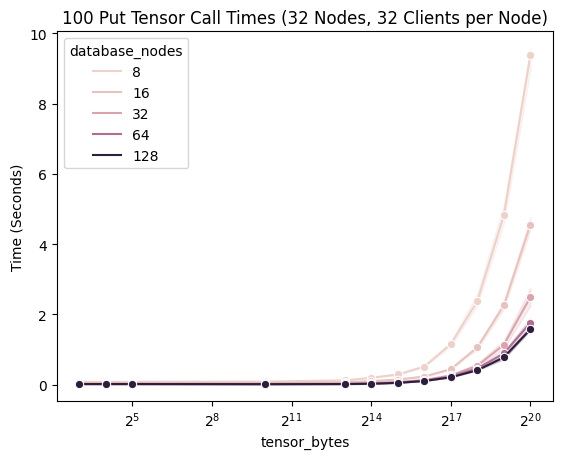

In [15]:
x = 'tensor_bytes'
y = 'Time (Seconds)'
hue = 'database_nodes'

put_call_time_data = put_tensor_data[[x, y, hue]]
plot = sns.lineplot(put_call_time_data, x=x, y=y, hue=hue,
                    errorbar=("pi", 50), marker='o')
plot.set(title=f"{ITERATIONS} Put Tensor Call Times {client_num_title}")
plot.set_xscale('log', base=2)

In [16]:
put_call_time_data

,tensor_bytes,Time (Seconds),database_nodes
685681,8,0.070554,8
685685,8,0.091907,8
685689,8,0.091796,8
685693,8,0.076217,8
685697,8,0.077034,8
...,...,...,...
931421,1048576,1.720627,128
931425,1048576,1.651210,128
931429,1048576,1.607582,128
931433,1048576,1.669331,128


### Put Tensor Throughput Per Client

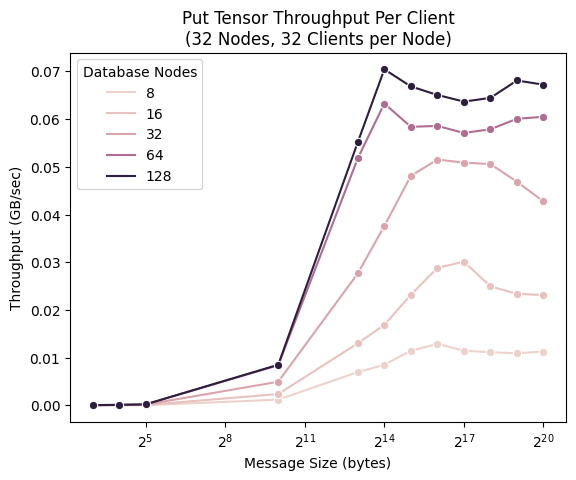

In [17]:
x = "Message Size (bytes)"
y = "Throughput (GB/sec)"
hue = "Database Nodes"

put_throughput_df = make_throughput_per_client_dataset(put_tensor_data, x, y, hue)
plot = sns.lineplot(put_throughput_df, x=x, y=y, hue=hue,
                    marker='o')
plot.set(title=f"Put Tensor Throughput Per Client\n{client_num_title}")
plot.set_xscale("log", base=2)

### Bandwidth per Node

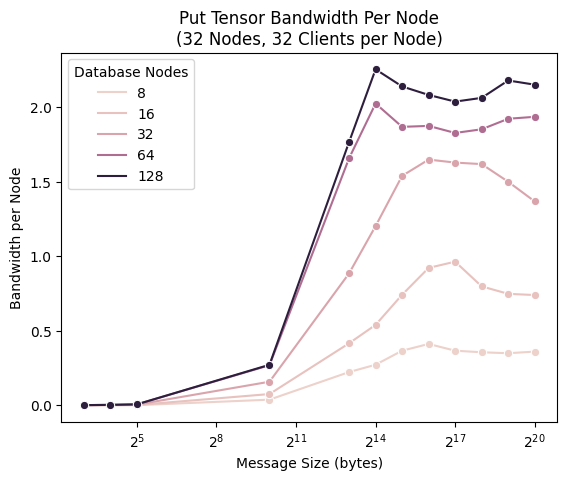

In [18]:
x = "Message Size (bytes)"
y = "Bandwidth per Node"
hue = "Database Nodes"

put_bandwidth_dataset = make_bandwidth_per_node_dataset(put_tensor_data, x, y, hue)
plot = sns.lineplot(put_bandwidth_dataset, x=x, y=y, hue=hue,
                    marker='o')
plot.set(title=f"Put Tensor Bandwidth Per Node\n{client_num_title}")
plot.set_xscale("log", base=2)

### Put Tensor Throughput Per DB

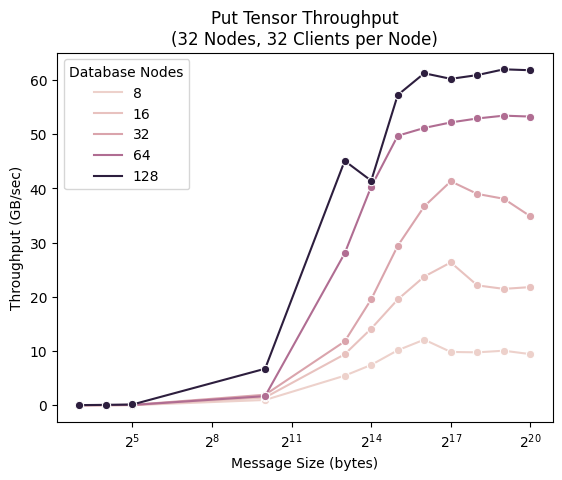

In [19]:
x = "Message Size (bytes)"
y = "Throughput (GB/sec)"
hue = "Database Nodes"

plot = sns.lineplot(make_observed_throughput_dataset(put_tensor_data, x, y, hue),
                    x=x, y=y, hue=hue,
                    marker='o')
plot.set(title=f"Put Tensor Throughput\n{client_num_title}")
plot.set_xscale('log', base=2)

### Get Tensor Times

In [20]:
get_tensor_data = plot_data[plot_data["Action"] == "unpack_tensor"]

In [21]:
get_tensor_data.tail()

,Rank,Action,Time (Seconds),client_nodes,clients_per_node,database_nodes,database_cpus,iterations,tensor_bytes
931422,647,unpack_tensor,1.429033,32,32,128,36,100,1048576
931426,510,unpack_tensor,2.215021,32,32,128,36,100,1048576
931430,781,unpack_tensor,1.529242,32,32,128,36,100,1048576
931434,176,unpack_tensor,2.165508,32,32,128,36,100,1048576
931438,10,unpack_tensor,2.233399,32,32,128,36,100,1048576


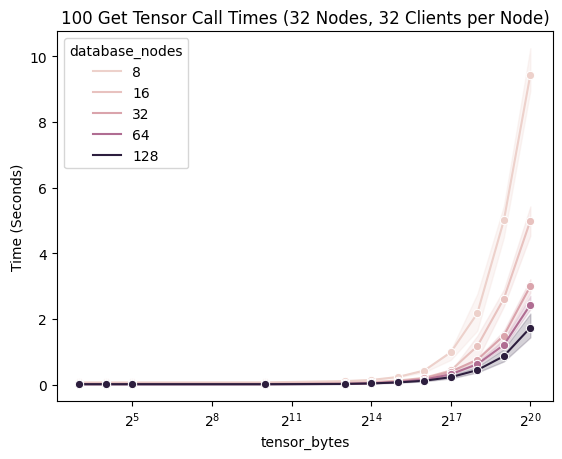

In [22]:
x = 'tensor_bytes'
y = 'Time (Seconds)'
hue = 'database_nodes'

get_call_time_data = get_tensor_data[[x, y, hue]]
plot = sns.lineplot(get_call_time_data, x=x, y=y, hue=hue,
                    errorbar=("pi", 50), marker='o')
plot.set(title=f"{ITERATIONS} Get Tensor Call Times {client_num_title}")
plot.set_xscale('log', base=2)
# plot.set_xticks(ax_tensor_bytes)
# plot.set_yscale('log', base=2)

### Get Tensor Throughput Per Client

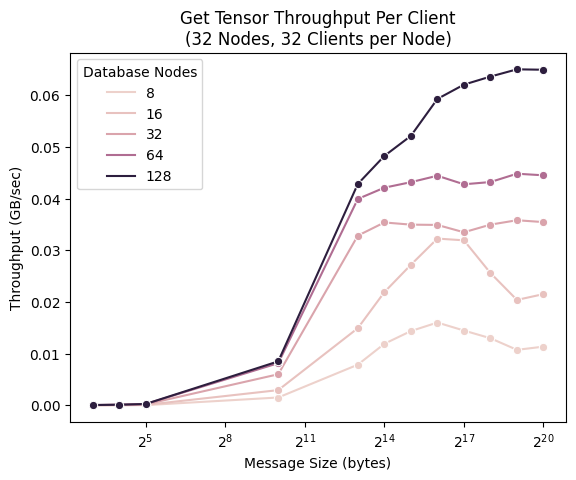

In [23]:
x = "Message Size (bytes)"
y = "Throughput (GB/sec)"
hue = "Database Nodes"

get_throughput_df = make_throughput_per_client_dataset(get_tensor_data, x, y, hue)
plot = sns.lineplot(get_throughput_df, x=x, y=y, hue=hue,
                    marker='o')
plot.set(title=f"Get Tensor Throughput Per Client\n{client_num_title}")
plot.set_xscale('log', base=2)

### Get Tensor Bandwidth per Node

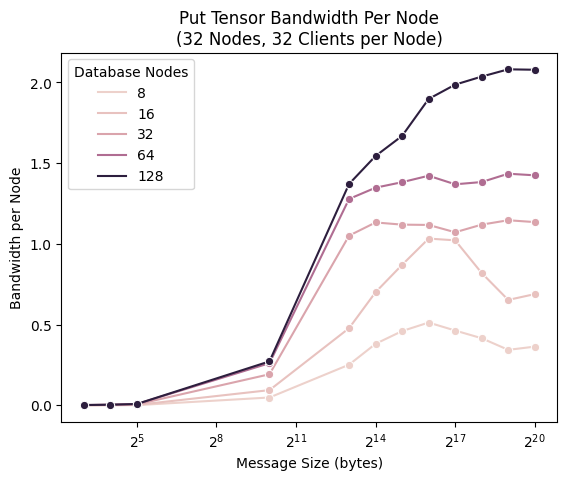

In [24]:
x = "Message Size (bytes)"
y = "Bandwidth per Node"
hue = "Database Nodes"

get_bandwidth_dataset = make_bandwidth_per_node_dataset(get_tensor_data, x, y, hue)
plot = sns.lineplot(get_bandwidth_dataset, x=x, y=y, hue=hue,
                    marker='o')
plot.set(title=f"Put Tensor Bandwidth Per Node\n{client_num_title}")
plot.set_xscale("log", base=2)

### Get Tensor Throughput Per DB

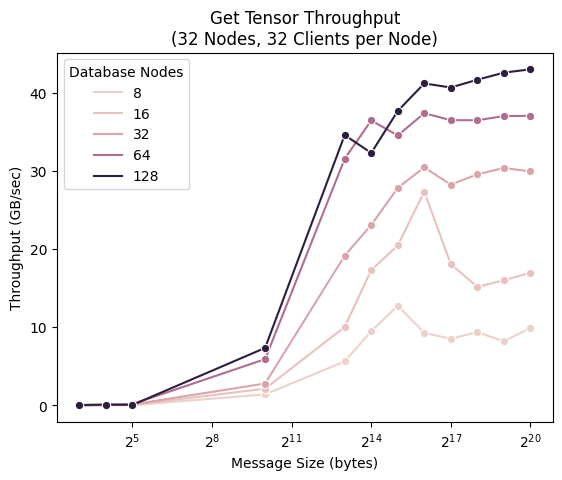

In [25]:
x = "Message Size (bytes)"
y = "Throughput (GB/sec)"
hue = "Database Nodes"

plot = sns.lineplot(make_observed_throughput_dataset(get_tensor_data, x, y, hue),
                    x=x, y=y, hue=hue,
                    marker='o')
plot.set(title=f"Get Tensor Throughput\n{client_num_title}")
plot.set_xscale('log', base=2)

## Latency per Client per Op

### Load Data

In [27]:
composite_latency_df = load_from_disk(PROCESSED_RESULTS_DIR, "fn-call-latency.csv")

In [28]:
LAT_NODES = 32
LAT_CLIENTS_PER_NODE = 32
LAT_DB_NODES = 32
LAT_TENSOR_BYTES = 8
lat_client_num_title = f"({LAT_NODES} Nodes, {LAT_CLIENTS_PER_NODE} Clients per Node, {LAT_DB_NODES} Database Nodes)"

latency_data = composite_latency_df[
      (composite_latency_df['client_nodes'] == LAT_NODES)
    & (composite_latency_df['clients_per_node'] == LAT_CLIENTS_PER_NODE)
    & (composite_latency_df['database_nodes'] == LAT_DB_NODES)
    & (composite_latency_df['database_cpus'] == 36)
    & (composite_latency_df['tensor_bytes'] == LAT_TENSOR_BYTES)
]

### Put Tensor

[Text(0.5, 1.0, 'Put Tensor Walltime\n(32 Nodes, 32 Clients per Node, 32 Database Nodes)')]

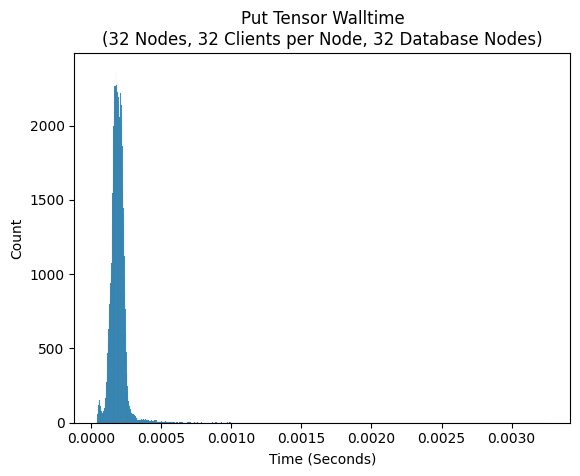

In [29]:
put_tensor_lat_data = latency_data[(latency_data['Action'] == "put_tensor")]
plot = sns.histplot(put_tensor_lat_data, x="Time (Seconds)")
plot.set(title=f"Put Tensor Walltime\n{lat_client_num_title}")

In [30]:
put_tensor_lat_data['Time (Seconds)'].describe()

count    102400.000000
mean          0.000191
std           0.000061
min           0.000041
25%           0.000161
50%           0.000188
75%           0.000215
max           0.003259
Name: Time (Seconds), dtype: float64

In [31]:
put_tensor_lat_data['Time (Seconds)'].quantile(.99)

0.00039817351702364973

[Text(0.5, 1.0, 'Get Tensor Walltime\n(32 Nodes, 32 Clients per Node, 32 Database Nodes)')]

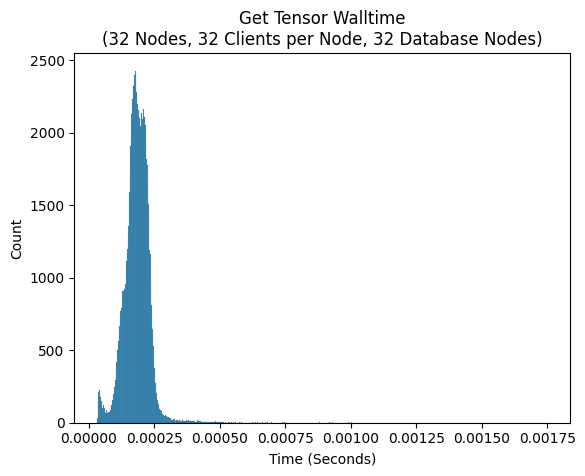

In [32]:
get_tensor_lat_data = latency_data[(latency_data['Action'] == "unpack_tensor")]
plot = sns.histplot(get_tensor_lat_data, x="Time (Seconds)")
plot.set(title=f"Get Tensor Walltime\n{lat_client_num_title}")

In [33]:
get_tensor_lat_data['Time (Seconds)'].describe()

count    102400.000000
mean          0.000183
std           0.000051
min           0.000031
25%           0.000158
50%           0.000184
75%           0.000212
max           0.001751
Name: Time (Seconds), dtype: float64

In [34]:
get_tensor_lat_data['Time (Seconds)'].quantile(.99)

0.0003161279496270265